# Homework 1. Binary classification metrics.
In this homework assignment, you are asked to implement several binary classification metrics and find out if the new model will be useful in production.
`model_v1_preds.csv` and `model_v2_preds.csv` contains predictions of current best production model and freshly trained one on test set. Test set was obtained this way:
1. Matches we can find with our production models was excluded from candidates set.
2. 5 categories was chosen: `Детские товары`, `Дом и сад`, `Строительство и ремонт`, `Товары для взрослых`, `Хобби и творчество`.
3. A 10k sample was taken from each category.
4. 50k pairs was labeled in crowd system (specially trained people answered the question of whether a pair of products is a match).

In [ ]:
from typing import List, Tuple, Dict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics import auc, precision_recall_curve, roc_auc_score

In [327]:
### load models predictions
model_v1_preds = pd.read_csv("model_v1_preds.csv")
model_v2_preds = pd.read_csv("model_v2_preds.csv")

### load real labels
real_labels = pd.read_csv("real_labels.csv")

In [3]:
real_labels["cat2"].value_counts()

Дом и сад                 9001
Хобби и творчество        8954
Строительство и ремонт    8905
Детские товары            8667
Товары для взрослых       7895
Name: cat2, dtype: int64

## Task 1. ROC AUC.

### Point estimate
Implement [ROC AUC](https://alexanderdyakonov.wordpress.com/2017/07/28/auc-roc-%D0%BF%D0%BB%D0%BE%D1%89%D0%B0%D0%B4%D1%8C-%D0%BF%D0%BE%D0%B4-%D0%BA%D1%80%D0%B8%D0%B2%D0%BE%D0%B9-%D0%BE%D1%88%D0%B8%D0%B1%D0%BE%D0%BA/) metric, apply it to both models' predictions, compare with metric values of `sklearn.metrics.roc_auc_score`.
You can use `sklearn.metrics.auc` to calculate area under the curve. You just need to get coordinates of the points of the curve.

In [329]:
def roc_auc_home_made(real_labels: pd.DataFrame, preds: pd.DataFrame) -> float:
    df = preds.merge(real_labels, on=["product_id_1", "product_id_2"])
    
    ### YOUR CODE HERE

In [330]:
assert round(roc_auc_home_made(real_labels, model_v1_preds), 4) \
== round(roc_auc_score(real_labels.target, model_v1_preds.score), 4)
assert round(roc_auc_home_made(real_labels, model_v2_preds), 4) \
== round(roc_auc_score(real_labels.target, model_v2_preds.score), 4)

In [1]:
print(f"ROC AUC v1: {round(roc_auc_score(real_labels.target, model_v1_preds.score), 4)}\n\
ROC AUC v2: {round(roc_auc_score(real_labels.target, model_v2_preds.score), 4)}")

### Bootstrap
#### Drawing conclusions based on a point estimate can be dangerous. You can use bootstrap to get more reliable results.

Implement metric with bootstrap using `sklearn.metrics.roc_auc_score`. This metric should take `n_iter` times a subsample of size N with replacement, calculate ROC AUC each time, and return list of metrics and its mean.

In [332]:
def roc_auc_w_bootstrap(real_labels: pd.DataFrame, 
                        preds: pd.DataFrame, 
                        n_iter: int = 1000) -> Tuple[float, List[float]]:
    ### YOUR CODE HERE
    ### use pandas.sample() with random_state = iteration number to pass assert

In [333]:
metric_1, metrics_list_1 = roc_auc_w_bootstrap(real_labels, model_v1_preds, n_iter=1000)
metric_2, metrics_list_2 = roc_auc_w_bootstrap(real_labels, model_v2_preds, n_iter=1000)

In [ ]:
assert round(metric_1, 4) == 0.8555
assert round(metric_2, 4) == 0.8715

In [2]:
print(f"ROC AUC v1: {round(metric_1, 4)}\nROC AUC v2: {round(metric_2, 4)}")

#### Plot histograms for each metrics list and write conclusions on these points:
1. Which model is better according to results?
2. Why is the spread of values is so small that the intervals do not intersect? 

In [3]:
plt.hist(metrics_list_1, density=False, bins=30);
plt.hist(metrics_list_2, density=False, bins=30);

### ROC AUC macro
In our test set there are several different categories. It could be useful to evaluate the quality of models in each category separately, because in production we can have different binarization thresholds for different categories. In the case when different categories have different data distributions, having unique threshold for each category can drastically increase recall (but for ROC AUC it is not necessary).

Implement ROC AUC macro metric using `sklearn.metrics.roc_auc_score`. `roc_auc_macro` should calculate ROC AUC for each category separately and then return weighted average. Weighting could be different: 
1. Weights could be equal to $\frac{1}{n\_categories}$ then the metric is the quality of the model on each category on average.
2. Weights could be proportional to categories sizes in production — then bigger categories will be more important and metric for this category will have bigger weight.
3. If we can somehow determine the weights according to business knowledge, we can use them. Actually not very realistic case.

Consider the possibility of each option in your implementation. Also keep in mind that you are provided with categories of two levels: `cat2` and `cat3`. `cat3` are subcategories of `cat2`. If we have enough resources we can set thresholds for large `cat3` and get better recall than with common threshold for entire `cat2`.

In [336]:
def roc_auc_macro(
    real_labels: pd.DataFrame, preds: pd.DataFrame, 
    cat_column: str = "cat2", cats_weights: Dict[str, float] = None
) -> Tuple[float, Dict[str, float]]:
    ### YOUR CODE HERE

In [337]:
metric_1, metrics_dict_1 = roc_auc_macro(real_labels, model_v1_preds, cat_column="cat2")
metric_2, metrics_dict_2 = roc_auc_macro(real_labels, model_v2_preds, cat_column="cat2")

In [ ]:
assert round(metric_1, 4) == 0.8501
assert round(metric_2, 4) == 0.8666

In [4]:
print(f"ROC AUC v1: {round(metric_1, 4)}\nROC AUC v2: {round(metric_2, 4)}")

**Think about why in this case the values of the macro metric turned out to be worse.**

---
It could be useful to look at the metric value in each category. If you have several new models and one is better in one category, another is better in another category, and you have enough resources, you can use different models for different categories in production.

In [5]:
metrics_dict_1

In [6]:
metrics_dict_2

Let's say we have category weights. Then we can calculate metric using these weights.

In [7]:
cats_weights = {
    'Детские товары': 0.1,
    'Строительство и ремонт': 0.1,
    'Товары для взрослых': 0.1,
    'Хобби и творчество': 0.2,
    'Дом и сад': 0.5
}

metric_1, metrics_dict_1 = roc_auc_macro(real_labels, model_v1_preds, cat_column="cat2", cats_weights=cats_weights)
metric_2, metrics_dict_2 = roc_auc_macro(real_labels, model_v2_preds, cat_column="cat2", cats_weights=cats_weights)

print(f"ROC AUC v1: {round(metric_1, 4)}\nROC AUC v2: {round(metric_2, 4)}")

#### * Thresholds by `cat3`

To find a reliable threshold for one category, on average, you need to get labels for 250 pairs of products. Each label costs 10 rubles, and for reliability three different assessors mark the same pair, so the total cost of one pair is 30 rubles. Based on this, suggest the number of `cat3` in which it is worth choosing a threshold. Suggest what to do with the rest `cat3`.

In [ ]:
metric_1, _ = roc_auc_macro(real_labels, model_v1_preds, cat_column="selected_cat3")
metric_2, _ = roc_auc_macro(real_labels, model_v2_preds, cat_column="selected_cat3")

print(f"ROC AUC v1: {round(metric_1, 4)}\nROC AUC v2: {round(metric_2, 4)}")

Compare metrics with metrics averaged by `cat2` and write conclusions.

#### It also could be useful to use bootstrap in macro metric to get more reliable results. 

## Task 2. PR curve.

Implement function that builds `PR curve`. PR curve is built according to the following algorithm:
1. The first point of curve is (0, 1).
2. Dataframe is sorted in descending order of predictions.
3. Starting from the first row, we calculate the precision and recall for the current line and all that are above it. Recall values are x-coordinates of curve, precision values — y-coordinates.
4. When recall reaches 1, finish collecting the coordinates.

Function should return coordinates of curve.

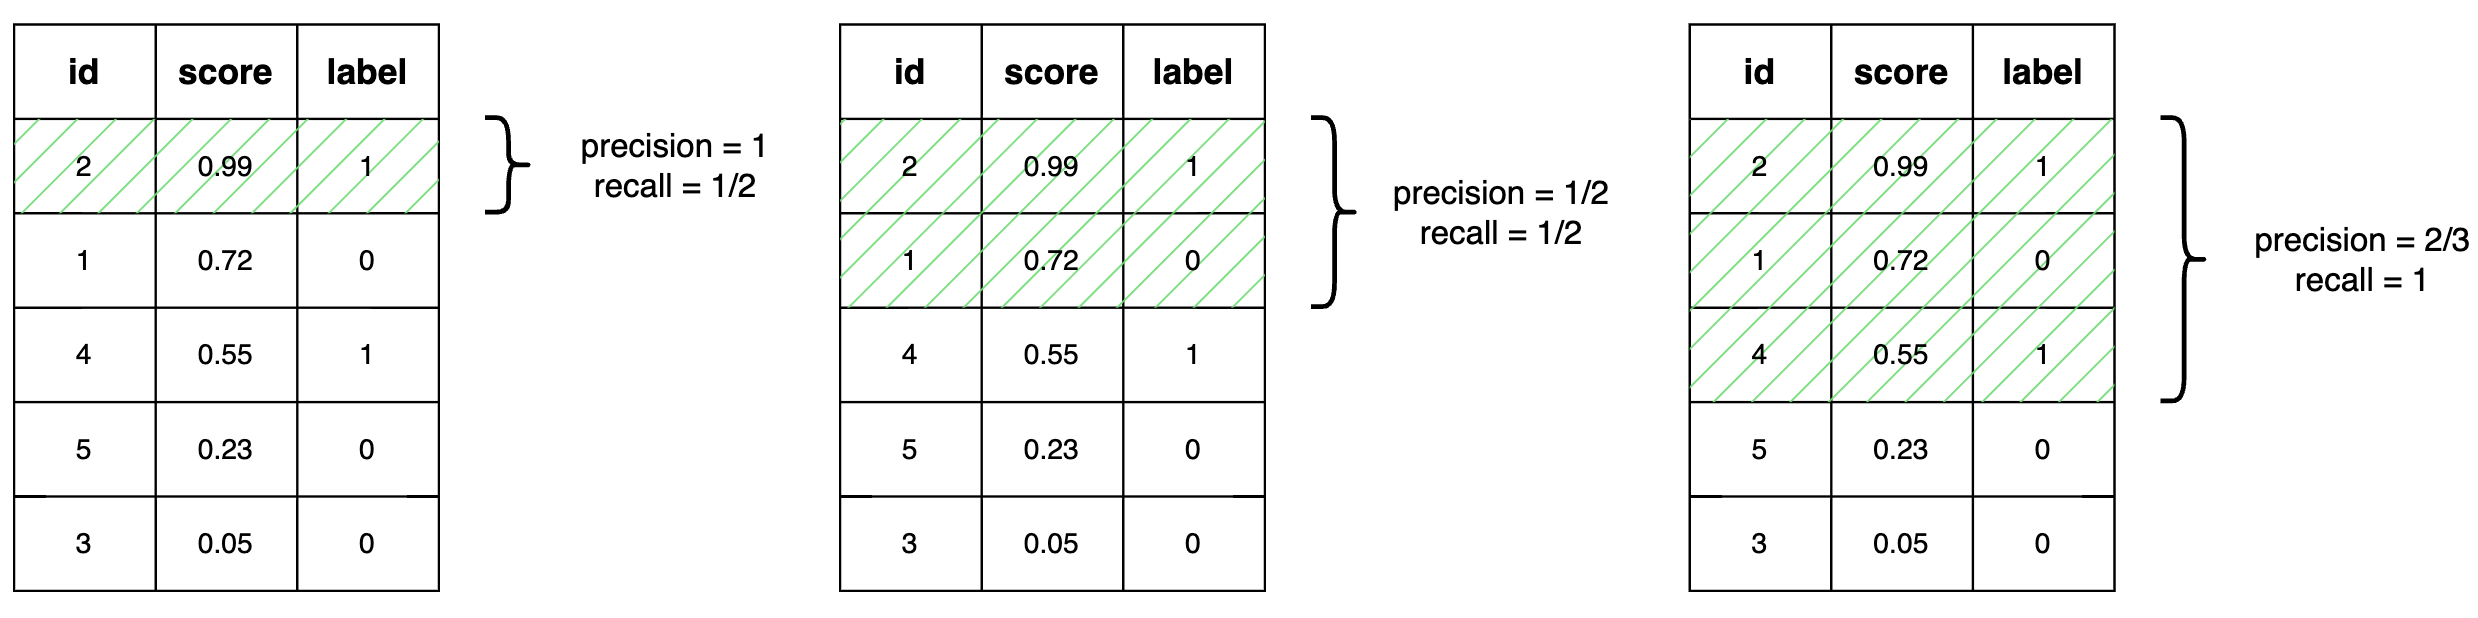

In [343]:
def pr_curve(real_labels: pd.DataFrame, preds: pd.DataFrame) -> Tuple[np.array, np.array]:
    ### YOUR CODE HERE

You can use `sklearn.metrics.auc` to calculate area under the curve. You just need to get coordinates of the points of the curve.

In [344]:
my_prec, my_rec = pr_curve(real_labels, model_v1_preds)
lib_prec, lib_rec, _ = precision_recall_curve(real_labels.target, model_v1_preds.score)
lib_prec = lib_prec[::-1]
lib_rec = lib_rec[::-1]
assert (my_prec - lib_prec).sum() == (my_rec - lib_rec).sum() == 0

### Recall (Precision = X%) / Precision (Recall = X%)
Implement function that calculates recall of a model for a certain precision and of a model for a certain recall. Compare `v1` and `v2` by these metrics.
You can use `sklearn.metrics.precision_recall_curve` to get curve coordinates.

In [373]:
def recall_at_precision(
    real_labels: pd.DataFrame, preds: pd.DataFrame, precision_lvl: float = 0.95
) -> float:
    ### YOUR CODE HERE


def precision_at_recall(
    real_labels: pd.DataFrame, preds: pd.DataFrame, recall_lvl: float = 0.5
) -> float:
    ### YOUR CODE HERE

#### Recall at precision

In [ ]:
assert round(recall_at_precision(real_labels, model_v1_preds, precision_lvl=0.95), 4) == 0.0123
assert round(recall_at_precision(real_labels, model_v2_preds, precision_lvl=0.95), 4) == 0.0551

In [8]:
print(f"v1 recall at 95% precision: {round(recall_at_precision(real_labels, model_v1_preds, precision_lvl=0.95), 4)}")
print(f"v2 recall at 95% precision: {round(recall_at_precision(real_labels, model_v2_preds, precision_lvl=0.95), 4)}")

In [9]:
print(f"v1 recall at 75% precision: {round(recall_at_precision(real_labels, model_v1_preds, precision_lvl=0.75), 4)}")
print(f"v2 recall at 75% precision: {round(recall_at_precision(real_labels, model_v2_preds, precision_lvl=0.75), 4)}")

#### Precision at recall

In [ ]:
assert round(precision_at_recall(real_labels, model_v1_preds, precision_lvl=0.5), 4) == 0.6264
assert round(precision_at_recall(real_labels, model_v2_preds, precision_lvl=0.5), 4) == 0.703

In [10]:
print(f"v1 precision at 50% recall: {round(precision_at_recall(real_labels, model_v1_preds, recall_lvl=0.5), 4)}")
print(f"v2 precision at 50% recall: {round(precision_at_recall(real_labels, model_v2_preds, recall_lvl=0.5), 4)}")

In [11]:
print(f"v1 precision at 30% recall: {round(precision_at_recall(real_labels, model_v1_preds, recall_lvl=0.3), 4)}")
print(f"v2 precision at 30% recall: {round(precision_at_recall(real_labels, model_v2_preds, recall_lvl=0.3), 4)}")

In [12]:
plt.figure(figsize=(15, 7))
plt.plot(v2_recall, v2_precision, label="v2")
plt.plot(v1_recall, v1_precision, label="v1")
plt.axhline(y=0.95, color='grey', linestyle='-.', label="95% prec")
plt.axhline(y=0.75, color='grey', linestyle='--', label="75% prec")
plt.axvline(x=0.5, color='tan', linestyle='-.', label="50% recall")
plt.axvline(x=0.3, color='tan', linestyle='--', label="30% recall")
plt.legend(fontsize=14)
plt.xlabel("Recall", fontsize=15)
plt.ylabel("Precision", fontsize=15);

### PR AUC
Implement PR AUC metric, using `sklearn.metrics.precision_recall_curve` and `sklearn.metrics.auc`. Compare models.

In [385]:
def pr_auc(real_labels: pd.DataFrame, preds: pd.DataFrame) -> float:
    ### YOUR CODE HERE

In [13]:
assert round(pr_auc(real_labels, model_v1_preds), 4) == 0.6005
assert round(pr_auc(real_labels, model_v2_preds), 4) == 0.6618

### PR AUC (Precision = X%)

In [398]:
def pr_auc_at_precision(
    real_labels: pd.DataFrame, preds: pd.DataFrame, precision_lvl: float = 0.95
) -> float:
    ### YOUR CODE HERE

In [15]:
assert round(pr_auc_at_precision(real_labels, model_v1_preds), 4) == 0.0118
assert round(pr_auc_at_precision(real_labels, model_v2_preds), 4) == 0.0537

### PR AUC (Precision = X%) macro

Let's say we have two use cases:
1. We want to give equal weights to each of groups.
2. We have production-like distribution in our target_df and we want to give each group the weight proportional to it size.

In [406]:
def pr_auc_at_precision_macro(
    target_df: pd.DataFrame,
    predictions_df: pd.DataFrame,
    prec_level: float = 0.95,
    cat_column: str = "cat2",
    weighted: bool = True
) -> Tuple[float, Dict[str, float]]:

    ### YOUR CODE HERE

In [20]:
metric_1, metrics_by_cat_1 = pr_auc_at_precision_macro(
    real_labels, model_v1_preds, weighted=False
)

In [18]:
metric_2, metrics_by_cat_2 = pr_auc_at_precision_macro(
    real_labels, model_v2_preds, weighted=False
)

In [ ]:
assert round(metric_1, 4) == 0.0194
assert round(metric_2, 4) == 0.081

## Task 3. Conclusions.

Having different metrics, analyze the relevance of each in relation to the task, selecting the best model for production. Think about the different business needs that determine which metric to consider as the main one.